<a href="https://colab.research.google.com/github/RohinSequeira/pytorch_resnet18/blob/main/pytorch_cifar10_resnet_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Training Concepts

In [1]:
import torch
import torch.optim as optim

from torchsummary import summary
from torch.optim.lr_scheduler import StepLR, OneCycleLR, ReduceLROnPlateau

import os
import numpy as np

In [2]:
%%capture
!git clone https://github.com/RohinSequeira/pytorch_cifar10.git
!pip install albumentations==1.0.0

In [3]:
from pytorch_cifar10 import main as main
from pytorch_cifar10.model import resnet as models
from pytorch_cifar10.utils import utils as utils
from pytorch_cifar10.utils.gradcam import generate_gradcam, plot_gradcam_images

## Data Loader & Albumentations

In [4]:
norm_mean,norm_std = utils.cifar10_mean_std()
train_transform, test_transform = utils.get_transforms(norm_mean,norm_std)

# Extract and transform the data
train_set,test_set = utils.get_datasets(train_transform,test_transform)

# Targets -> ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = train_set.classes

# Dataloader Arguments & Test/Train Dataloaders - Load part of ETL
train_loader,test_loader = utils.get_dataloaders(train_set,test_set)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
(0.492, 0.483, 0.447) (0.247, 0.243, 0.262)


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:645: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying 10 images


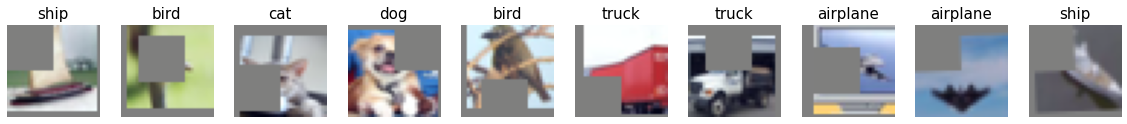

In [5]:
# Explore sample images
utils.show_sample_images(train_loader, classes, .5, .25, num_of_images = 10)

## Model Summary

In [6]:
# Model summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = models.ResNet18("LN").to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
         GroupNorm-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
         GroupNorm-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
         GroupNorm-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
         GroupNorm-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
        GroupNorm-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
        GroupNorm-14          [-1,

## Training & Testing the Model

In [7]:
EPOCH = 40
batch_size = 256
l1_factor = 0
l2_factor = 0.0001
lr_value = 0.001
mt_val = 0.9

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

utils.seed_everything(1)

optimizer = optim.Adam(model.parameters(), lr=lr_value, weight_decay=l2_factor)
scheduler = ReduceLROnPlateau(optimizer, factor=0.2, patience=3,verbose=True,mode='max')

print("------------------------------------------")
train_loss, test_loss, train_acc, test_acc = main.main(EPOCH, model, device, train_loader, test_loader, optimizer, scheduler, l1_factor)

------------------------------------------

Epoch 1 : 
Train set: Average loss: 1.8551, Accuracy: 21.33

Test set: Average loss: 0.014, Accuracy: 34.83

Epoch 2 : 
Train set: Average loss: 1.4867, Accuracy: 33.75

Test set: Average loss: 0.013, Accuracy: 37.48

Epoch 3 : 
Train set: Average loss: 1.7158, Accuracy: 39.68

Test set: Average loss: 0.012, Accuracy: 45.32

Epoch 4 : 
Train set: Average loss: 1.7275, Accuracy: 43.47

Test set: Average loss: 0.011, Accuracy: 49.65

Epoch 5 : 
Train set: Average loss: 1.3879, Accuracy: 47.92

Test set: Average loss: 0.010, Accuracy: 54.04

Epoch 6 : 
Train set: Average loss: 1.0638, Accuracy: 52.44

Test set: Average loss: 0.009, Accuracy: 60.40

Epoch 7 : 
Train set: Average loss: 1.0923, Accuracy: 56.17

Test set: Average loss: 0.008, Accuracy: 63.93

Epoch 8 : 
Train set: Average loss: 0.9969, Accuracy: 59.45

Test set: Average loss: 0.008, Accuracy: 64.88

Epoch 9 : 
Train set: Average loss: 1.0940, Accuracy: 62.18

Test set: Average loss:

## Accuracy and Loss Plots

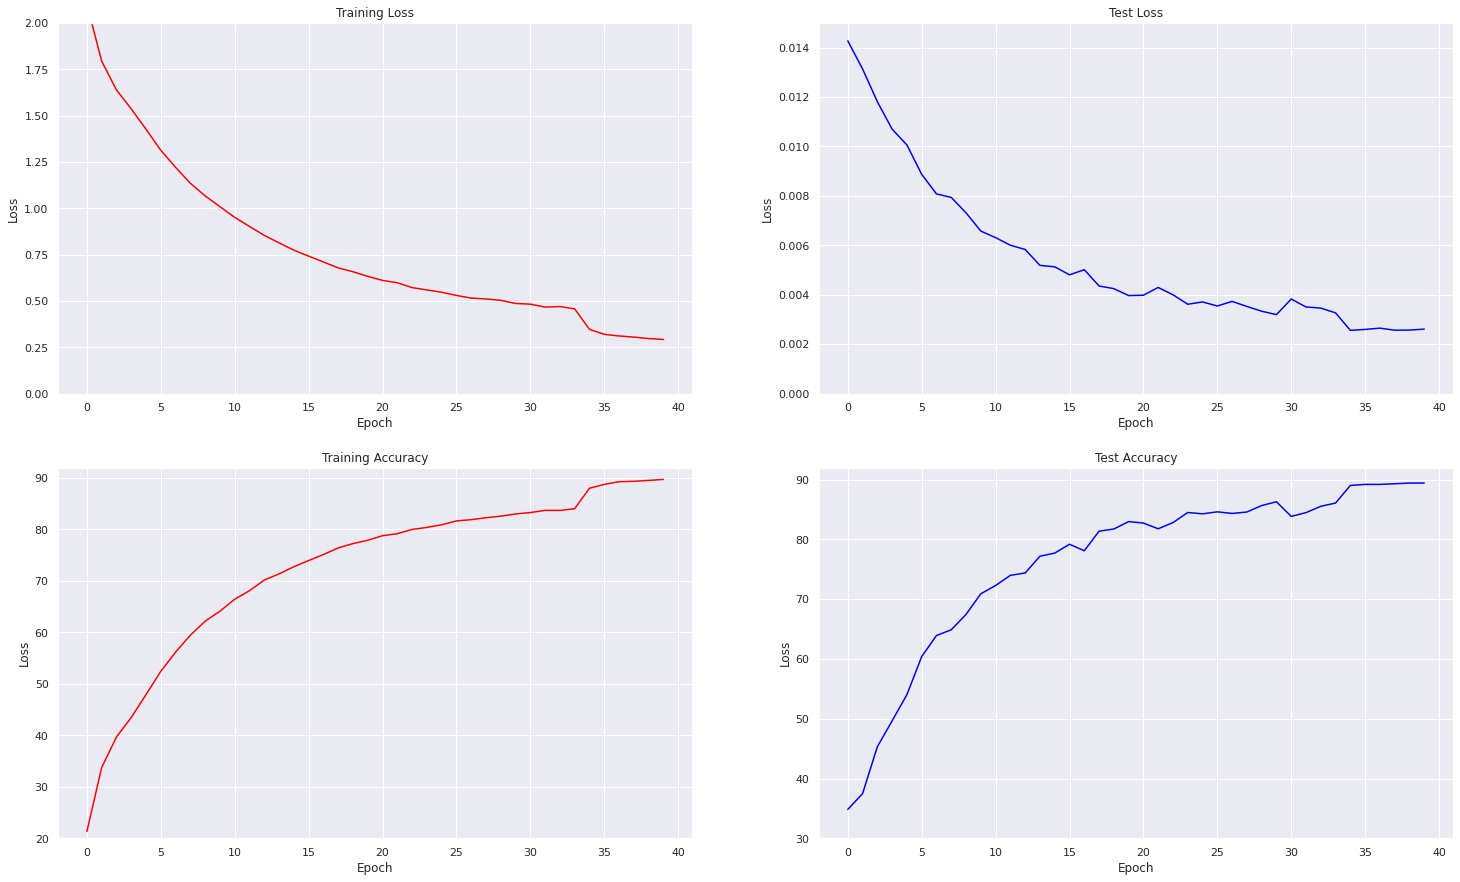

In [8]:
utils.valid_accuracy_loss_plots(train_loss, train_acc, test_loss, test_acc)

## Misclassified images

In [10]:
def wrong_predictions(model,test_loader, norm_mean, norm_std, classes):
    wrong_images=[]
    wrong_label=[]
    correct_label=[]
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True).squeeze()  # get the index of the max log-probability

            wrong_pred = (pred.eq(target.view_as(pred)) == False)
            wrong_images.append(data[wrong_pred])
            wrong_label.append(pred[wrong_pred])
            correct_label.append(target.view_as(pred)[wrong_pred])  

            wrong_predictions = list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))
        print(f'Total wrong predictions are {len(wrong_predictions)}')

        plot_misclassified(wrong_predictions, norm_mean, norm_std, classes)

    return wrong_predictions

In [12]:
def plot_misclassified(wrong_predictions, norm_mean, norm_std, classes):
    fig = plt.figure(figsize=(10,12))
    fig.tight_layout()
    for i, (img, pred, correct) in enumerate(wrong_predictions[:20]):
        img, pred, target = img.cpu().numpy().astype(dtype=np.float32), pred.cpu(), correct.cpu()
        for j in range(img.shape[0]):
            img[j] = (img[j]*norm_std[j])+norm_mean[j]

        img = np.transpose(img, (1, 2, 0)) #/ 2 + 0.5
        ax = fig.add_subplot(5, 5, i+1)
        ax.axis('off')
        ax.set_title(f'\nactual : {classes[target.item()]}\npredicted : {classes[pred.item()]}',fontsize=10)
        ax.imshow(img)

    plt.show()

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

Total wrong predictions are 1057


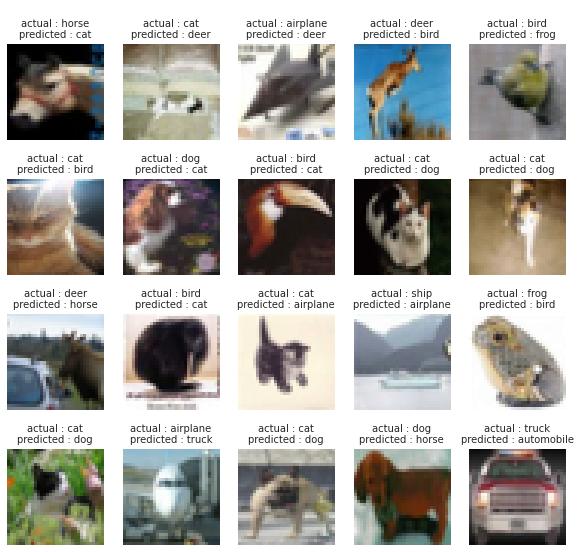

In [15]:
misclassified_images = wrong_predictions(model,test_loader, norm_mean, norm_std, classes)

## GradCAM images for same 20 misclassified images 

In [16]:
%%capture
target_layers = ["layer1","layer2","layer3","layer4"]
gradcam_output, probs, predicted_classes = generate_gradcam(misclassified_images[:20], model, target_layers,device)

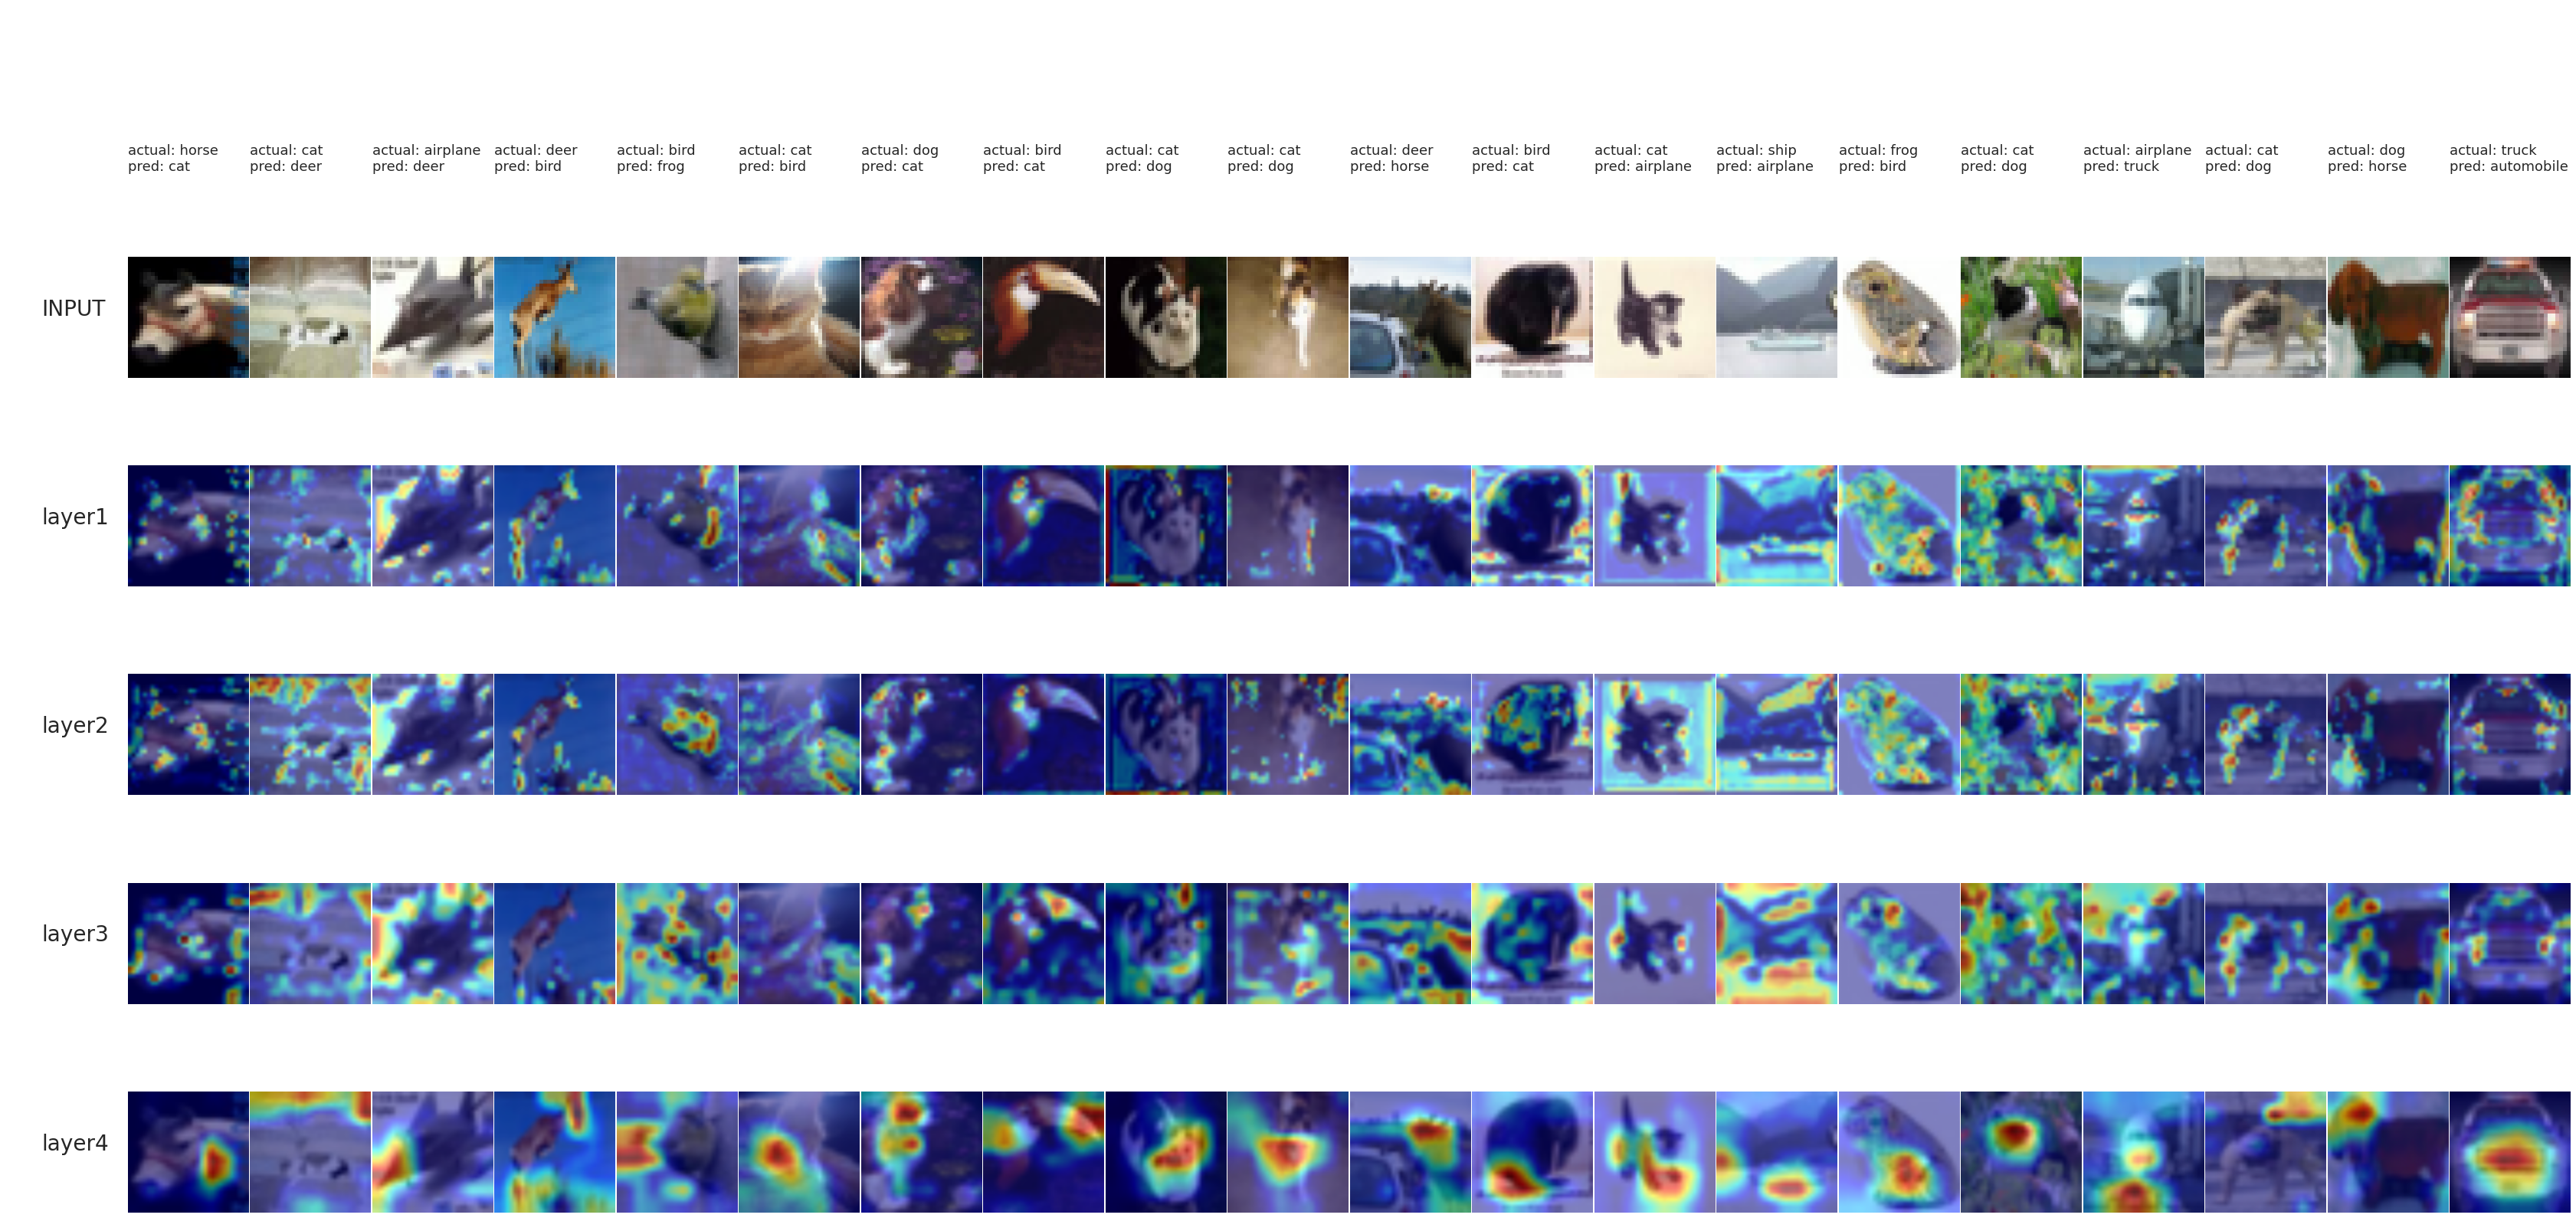

In [17]:
plot_gradcam_images(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, misclassified_images[:20])